## Importing libraries

In [2]:
!pip install patchify
# !pip install -U tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 81.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
!pip install -U segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.3 MB/s eta 0:00:00


In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image

import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tqdm import tqdm
import random
import pickle
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

Segmentation Models: using `tf.keras` framework.


## 1. Resizing the images to smaller dimensions

In [5]:
sm.set_framework('tf.keras')

### 1.1 Data Loading and manipulation

In [6]:
def data_loader(image_dir, mask_dir):
    image_dataset = []
    mask_dataset = []

    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    for img_name, mask_name in zip(image_filenames, mask_filenames):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)

        # Read image and mask
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        # Skip unreadable files
        if image is None or mask is None:
            print(f"❌ Skipping file pair: {img_name}, {mask_name}")
            continue

        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # Resize both image and mask
        image = cv2.resize(image, (128, 128))
        mask = cv2.resize(mask, (128, 128))

        image_dataset.append(image)
        mask_dataset.append(mask)

    print(f"✅ Loaded {len(image_dataset)} image-mask pairs from:")
    print(f"   Images: {image_dir}")
    print(f"   Masks : {mask_dir}")

    return np.array(image_dataset), np.array(mask_dataset)


In [7]:
image_folder = "/content/drive/MyDrive/Aerial Semantic Segmentation/dataset/semantic_drone_dataset/original_images/"
mask_folder = "/content/drive/MyDrive/Aerial Semantic Segmentation/RGB_color_image_masks/RGB_color_image_masks"

image_dataset, mask_dataset = data_loader(image_folder, mask_folder)

✅ Loaded 400 image-mask pairs from:
   Images: /content/drive/MyDrive/Aerial Semantic Segmentation/dataset/semantic_drone_dataset/original_images/
   Masks : /content/drive/MyDrive/Aerial Semantic Segmentation/RGB_color_image_masks/RGB_color_image_masks


In [8]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [9]:
mask_dataset.shape

(400, 128, 128, 3)

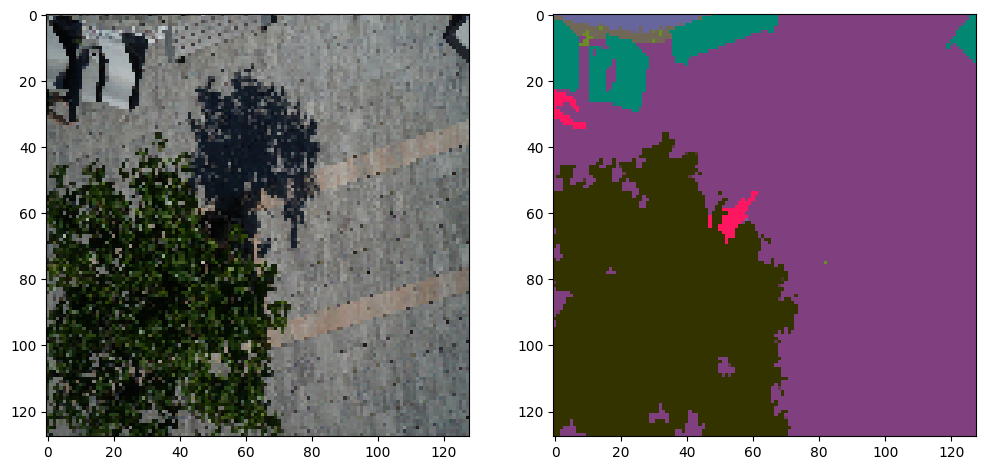

In [10]:
# Sanity check...
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [14]:
# mask labels RGB values
mask_labels = pd.read_csv("/content/drive/MyDrive/Aerial Semantic Segmentation/class_dict_seg.csv")

In [12]:
mask_labels

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [9]:
# converting 3 values (RGB) to 1 label values
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape, dtype=np.uint8)

    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis = -1)] = i

    label_seg = label_seg[:, :, 0] #Just take the first channel, no need for all 3 channels

    return label_seg

In [14]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_labels(mask_dataset[i], mask_labels) # calling rgb to labels for each images
    labels.append(label)

In [15]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3) # adding channel dimensions

Unique labels in label dataset are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


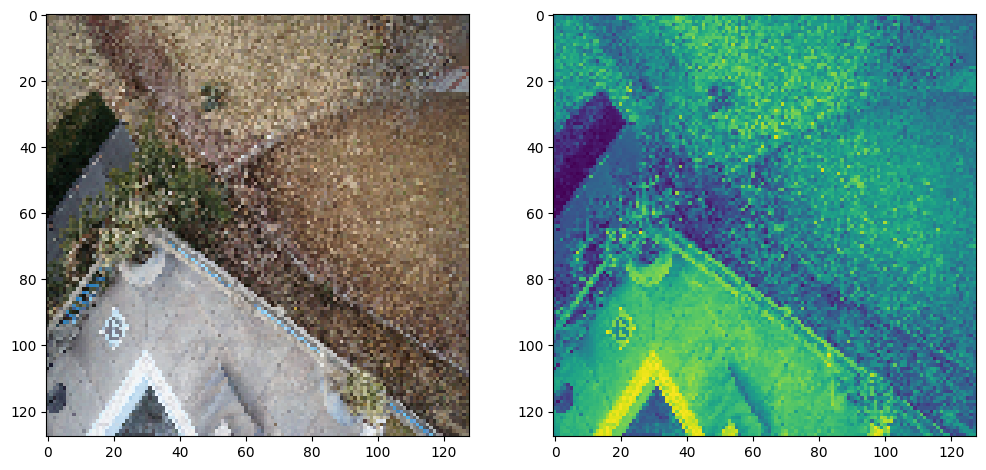

In [18]:
print("Unique labels in label dataset are: ", np.unique(labels)) # check for unique labels

#Another Sanity check
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(image_dataset[image_number][:, :, 0])
plt.show()

In [19]:
n_classes = len(np.unique(labels)) # 23 classes
labels_cat = to_categorical(labels, num_classes=n_classes) # one hot encoding the labels

In [20]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42) # train test split for data

### 1.2 Modelling

We are using resnet pre-trained model to set the initial weights of the UNet. Below is the architecture of the Resnet34:

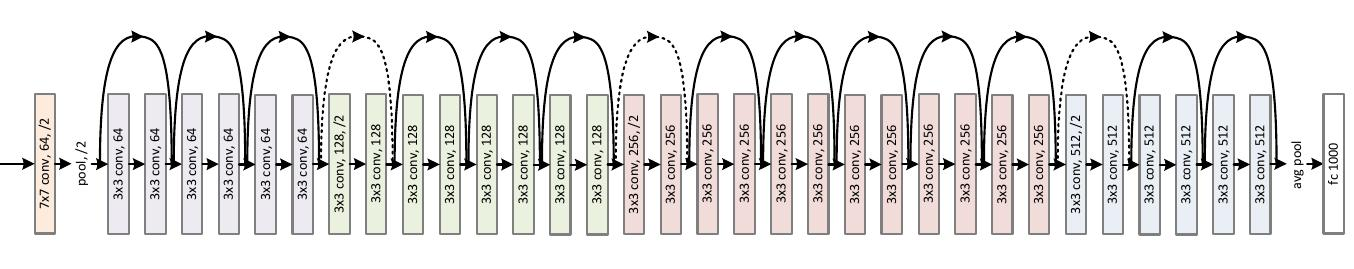

In [21]:
# using weight from resnet 34
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [22]:
# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

We are using UNet architecture to train our model for semantic segmentation
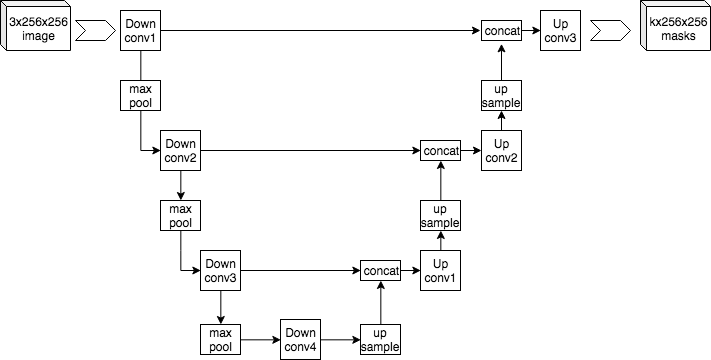

In [23]:
# defining model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights = 'imagenet', classes = n_classes, activation='softmax')

85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [24]:
# accuracy as metrics, adam optimizer and loss function that needs to be optimized is categorical crossentropy as its a multiclass classification problem
metrics = ['accuracy']
model_resnet_backbone.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= metrics)

In [27]:
model_resnet_backbone.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, None,      │      4,096 │ stage1_unit1_rel

 Total params: 24,459,344 (93.30 MB)

 Trainable params: 24,441,994 (93.24 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [ ]:
# training model for 100 epochs with batch size = 16
history = model_resnet_backbone.fit(
    X_train_prepr, y_train,
    batch_size = 16,
    epochs=100,
    verbose = 1,
    validation_data = (X_test_prepr, y_test)
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 226s 9s/step - accuracy: 0.2455 - loss: 2.6904 - val_accuracy: 0.3638 - val_loss: 54.8648
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 173s 9s/step - accuracy: 0.5488 - loss: 1.6796 - val_accuracy: 0.3430 - val_loss: 10899.8301
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 177s 9s/step - accuracy: 0.5967 - loss: 1.4528 - val_accuracy: 0.0961 - val_loss: 1297.5242
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 220s 10s/step - accuracy: 0.6512 - loss: 1.2704 - val_accuracy: 0.2513 - val_loss: 2430.2205
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 202s 10s/step - accuracy: 0.6342 - loss: 1.2654 - val_accuracy: 0.2615 - val_loss: 136.7096
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 194s 10s/step - accuracy: 0.6520 - loss: 1.2190 - val_accuracy: 0.3997 - val_loss: 11.6417
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 178s 8s/step - accuracy: 0.6662 - loss: 1.1384 - val_accuracy: 0.4712 - val_loss: 6.7082
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 206s 8s/step - accuracy: 0.6782 - loss: 1.0766 -

### 1.3 Results

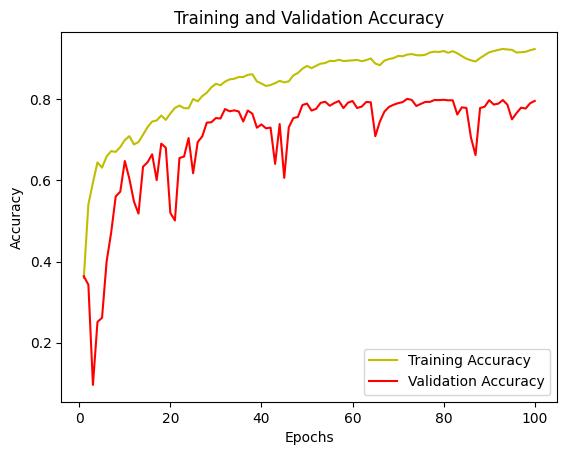

In [ ]:
# plotting train and val accuracy in each epoch
history = history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model_resnet_backbone.save('/content/drive/MyDrive/Aerial Semantic Segmentation/dataset/model_resnet_backbone.keras') # model saving

In [7]:
model = load_model('/content/drive/MyDrive/Aerial Semantic Segmentation/dataset/model_resnet_backbone.keras') # model loading

In [26]:
# making predictions
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis = 3)
y_test_argmax = np.argmax(y_test, axis = 3)

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


In [27]:
# randomly selecting an image from the test set and making prediction
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test_argmax[test_img_number]

In [28]:
test_img_input = np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0, :, :]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


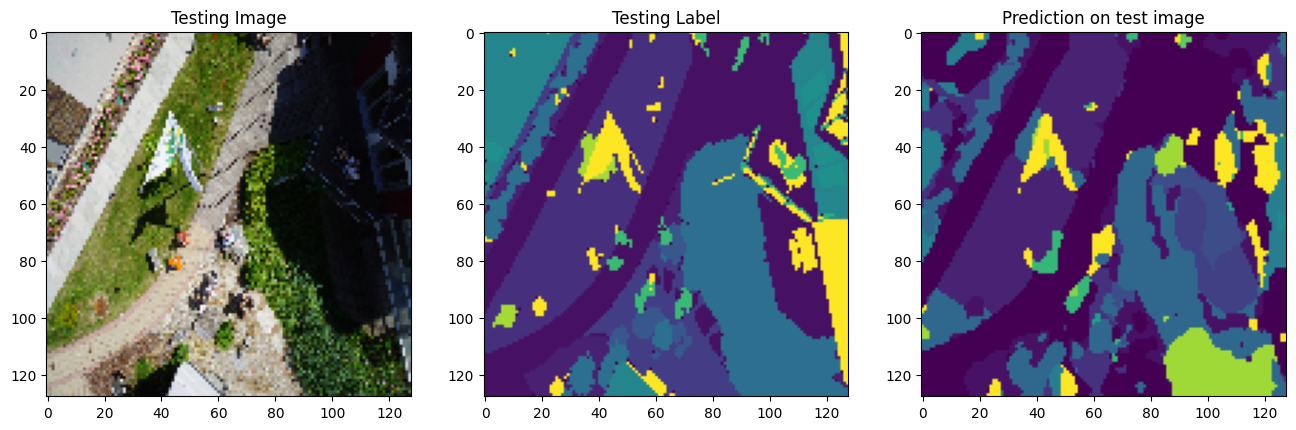

In [32]:
# plotting the real image, test labeled image and predicted labeled image
plt.figure(figsize = (16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()